In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
cd '/content/drive/My Drive/Image_Audio_clustering_GSOC2020/'

[Errno 2] No such file or directory: '/content/drive/My Drive/Image_Audio_clustering_GSOC2020/'
/content


In [3]:
"""
import zipfile
zip_ref = zipfile.ZipFile('ideology_image_dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('muslim_image_dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()
"""

"\nimport zipfile\nzip_ref = zipfile.ZipFile('ideology_image_dataset.zip', 'r')\nzip_ref.extractall()\nzip_ref.close()\n\nzip_ref = zipfile.ZipFile('muslim_image_dataset.zip', 'r')\nzip_ref.extractall()\nzip_ref.close()\n"

In [4]:
!ls

'Clustering algorithms.gdoc'   Image_clustering.ipynb
 ideology_image_dataset        muslim_image_dataset
 ideology_image_dataset.zip    muslim_image_dataset.zip
 ideology.npy		       muslim.npy
 image_audio_clustering.gdoc


In [0]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.cluster import KMeans,AgglomerativeClustering,DBSCAN,OPTICS,MeanShift
import os, shutil, glob, os.path
from PIL import Image as pil_image
from matplotlib import pyplot as plt

import sklearn

from sklearn.metrics import pairwise_distances
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import davies_bouldin_score



In [6]:
model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
image.LOAD_TRUNCATED_IMAGES = True

# Variables
#method = "kmeans"
#method = "hierarchical"
imdir_ideology = 'ideology_image_dataset/'
imdir_muslim='muslim_image_dataset/'
number_clusters = 500
threshold = 2000.0 # needs to be float
targetdirbase_ideology = "ideology_cluster_output/"
targetdirbase_muslim="muslim_cluster_output/"

In [8]:
ideology_files=os.listdir('ideology_image_dataset/')
muslim_files=os.listdir('muslim_image_dataset/')
len(ideology_files),len(muslim_files)

(2942, 242)

In [0]:
ideology_files_path=[os.path.join(imdir_ideology,file) for file in ideology_files ]
muslim_files_path=[os.path.join(imdir_muslim,file) for file in muslim_files]

In [10]:
ideology_files_path[0],muslim_files_path[0]

('ideology_image_dataset/clip_2797.jpg',
 'muslim_image_dataset/t__0473496c_295d_11e6_844a_089e01ba0335.jpg')

In [0]:
def visualize_dataset(file_paths):
  rows=2
  for num, x in enumerate(file_paths[0:12]):
      img = pil_image.open(x)
      plt.subplot(rows,6,num+1)
      #plt.title(x.split('.')[0])
      plt.axis('off')
      plt.imshow(img)

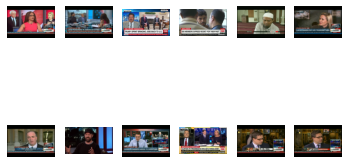

In [0]:
visualize_dataset(ideology_files_path)

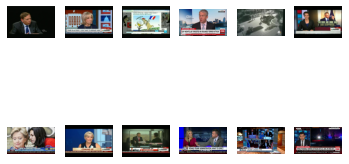

In [0]:
visualize_dataset(muslim_files_path)

In [0]:
 # the function is used to calculate the features from the image 
 def get_features(filelist): 
  filelist.sort()
  featurelist = []
  for i, imagepath in enumerate(filelist):
    print(" Status: %s / %s" %(i, len(filelist)), end="\r")
    img = image.load_img(imagepath, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = np.array(model.predict(img_data))
    featurelist.append(features.flatten())
  return featurelist

In [0]:
# calculating the muslim and the ideology features 
ideology_features=get_features(ideology_files_path)
muslim_features=get_features(muslim_files_path)
len(ideology_features),len(muslim_features)

In [0]:
# saving the idelogy and the muslim features 
with open('ideology.npy', 'wb') as f:
    np.save(f, np.array(ideology_features))

with open('muslim.npy', 'wb') as f:
    np.save(f, np.array(muslim_features))

In [0]:
# lets get started with the clustering 

def agglomerativeClustering(features,silhouette_df,calinksi_df,davies_df,cluster_df):
  thresholds=[500,2000,3000,4000,5000]
  linkages=['ward','average','complete','single']
  
  for threshold in thresholds:
    for linkage in linkages:
      try:
        print("Running for ",threshold,linkage)
        agglomerative_model = AgglomerativeClustering(n_clusters=None,distance_threshold=threshold,linkage=linkage).fit(np.array(features))
        labels =  agglomerative_model.labels_
        silhouette_score=metrics.silhouette_score(np.array(features), labels, metric='euclidean')
        calinksi_score=metrics.calinski_harabasz_score(np.array(features), labels)
        davies_score=davies_bouldin_score(np.array(features), labels)
        n_clusters_ = len(set(labels))
        print("scoring for ",threshold,linkage,calinksi_score,davies_score,n_clusters_)
        silhouette_df.loc[str(threshold),linkage]=silhouette_score
        calinksi_df.loc[str(threshold),linkage]=calinksi_score
        davies_df.loc[str(threshold),linkage]=davies_score
        cluster_df.loc[str(threshold),linkage]=n_clusters_
      
      except ValueError as v:
        silhouette_df.loc[str(threshold),linkage]=0
        calinksi_df.loc[str(threshold),linkage]=0
        davies_df.loc[str(threshold),linkage]=0
        cluster_df.loc[str(threshold),linkage]=1
        
        pass

      

      
  
  return silhouette_df,calinksi_df,davies_df,cluster_df,labels



In [0]:
#calling the agglomerative clustering for muslim / ideology dataset 
silhouette_df= pd.DataFrame(index=['500','2000','3000','4000','5000'],columns=['ward','average','complete','single'])
calinksi_df=pd.DataFrame(index=['500','2000','3000','4000','5000'],columns=['ward','average','complete','single'])
davies_df=pd.DataFrame(index=['500','2000','3000','4000','5000'],columns=['ward','average','complete','single'])
cluster_df=pd.DataFrame(index=['500','2000','3000','4000','5000'],columns=['ward','average','complete','single'])
#uncomment any one of them to run 
#silhouette_df,calinksi_df,davies_df,cluster_df,labels=agglomerativeClustering(muslim_features,silhouette_df,calinksi_df,davies_df,cluster_df)#for muslim 
#silhouette_df,calinksi_df,davies_df,cluster_df,labels=agglomerativeClustering(ideology_features,silhouette_df,calinksi_df,davies_df,cluster_df)#for ideology



In [0]:
def optics(features,silhouette_df,calinksi_df,davies_df,cluster_df):
  epsilons=[3,3.5,4]
  min_samples=[5,15,30]
  for epsilon in epsilons:
    for min_sample in min_samples:
      try:
            print("Running for the episold and min samples",epsilon,min_sample)

            optics_model=OPTICS(eps=epsilon,min_samples=min_sample).fit(np.array(features))
            labels = optics_model.labels_
            
            silhouette_score=metrics.silhouette_score(np.array(features), labels, metric='euclidean')
            calinksi_score=metrics.calinski_harabasz_score(np.array(features), labels)
            davies_score=davies_bouldin_score(np.array(features), labels)
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

            print("scoring for ",epsilon,min_sample,silhouette_score,calinksi_score,davies_score)
            silhouette_df.loc[str(epsilon),str(min_sample)]=silhouette_score
            calinksi_df.loc[str(epsilon),str(min_sample)]=calinksi_score
            davies_df.loc[str(epsilon),str(min_sample)]=davies_score
            cluster_df.loc[str(epsilon),str(min_sample)]=n_clusters_

      except ValueError as e:
            silhouette_df.loc[str(epsilon),str(min_sample)]=0
            calinksi_df.loc[str(epsilon),str(min_sample)]=0
            davies_df.loc[str(epsilon),str(min_sample)]=0
            cluster_df.loc[str(epsilon),str(min_sample)]=1



In [0]:
#calling the optics clustering for the ideology/ muslim data
silhouette_df_optics= pd.DataFrame(index=['3','3.5','4'],columns=['5','15','30'])
calinksi_df_optics=pd.DataFrame(index=['3','3.5','4'],columns=['5','15','30'])
davies_df_optics=pd.DataFrame(index=['3','3.5','4'],columns=['5','15','30'])
cluster_df_optics=pd.DataFrame(index=['3','3.5','4'],columns=['5','15','30'])
silhouette_df_optics,calinksi_df_optics,davies_df_optics,cluster_df_optics,labels=optics(muslim_features,silhouette_df_optics,calinksi_df_optics,davies_df_optics,cluster_df_optics)#for muslim 
silhouette_df_optics,calinksi_df_optics,davies_df_optics,cluster_df_optics,labels=optics(ideology_features,silhouette_df_optics,calinksi_df_optics,davies_df_optics,cluster_df_optics)#for ideology
#for ideology 


In [0]:
def dbscan(features,silhouette_df,calinksi_df,davies_df,cluster_df):
      epsilons=[3,3.5,4]
      min_samples=[5,15,30]

      for epsilon in epsilons:
        for min_sample in min_samples:
          try:
            print("Running for the episold and min samples",epsilon,min_samples)

            dbscan_model=DBSCAN(eps=epsilon,min_samples=min_sample).fit(np.array(features))
            labels = dbscan_model.labels_
            
            silhouette_score=metrics.silhouette_score(np.array(features), labels, metric='euclidean')
            calinksi_score=metrics.calinski_harabasz_score(np.array(features), labels)
            davies_score=davies_bouldin_score(np.array(features), labels)
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            
            print("scoring for ",epsilon,min_sample,silhouette_score,calinksi_score,davies_score)
            silhouette_df.loc[str(epsilon),str(min_sample)]=silhouette_score
            calinksi_df.loc[str(epsilon),str(min_sample)]=calinksi_score
            davies_df.loc[str(epsilon),str(min_sample)]=davies_score
            cluster_df.loc[str(epsilon),str(min_sample)]=n_clusters_


      
          except ValueError as v:
            silhouette_df.loc[str(epsilon),str(min_sample)]=0
            calinksi_df.loc[str(epsilon),str(min_sample)]=0
            davies_df.loc[str(epsilon),str(min_sample)]=0
            cluster_df.loc[str(epsilon),str(min_sample)]=1

           
            
            

      return silhouette_df,calinksi_df,davies_df,cluster_df,labels

In [0]:
#dbscan clustering for the ideology and the muslim

silhouette_df_dbscan= pd.DataFrame(index=['3','3.5','4'],columns=['5','15','30'])
calinksi_df_dbscan=pd.DataFrame(index=['3','3.5','4'],columns=['5','15','30'])
davies_df_dbscan=pd.DataFrame(index=['3','3.5','4'],columns=['5','15','30'])
cluster_df_dbscan=pd.DataFrame(index=['3','3.5','4'],columns=['5','15','30'])
silhouette_df_dbscan,calinksi_df_dbscan,davies_df_dbscan,cluster_df_dbscan,labels=dbscan(muslim_features,silhouette_df_dbscan,calinksi_df_dbscan,davies_df_dbscan,cluster_df_dbscan)#for muslim 
#silhouette_df_dbscan,calinksi_df_dbscan,davies_df_dbscan,cluster_df_dbscan,labels=dbscan(ideology_features,silhouette_df_dbscan,calinksi_df_dbscan,davies_df_dbscan,cluster_df_dbscan)# for ideology



In [0]:
def mean_shift(features,silhouette_df,calinksi_df,davies_df,cluster_df):
      quantiles=[0.2,0.4,0.6,0.8]
      n_samples=[500,1000]

      for quantile in quantiles:
        for n_sample in n_samples:
          try:
            print("Running for the episold and min samples",quantile,n_sample)
            bandwidth = sklearn.cluster.estimate_bandwidth(np.array(features), quantile=quantile, n_samples=n_sample)
            mean_model=MeanShift(bandwidth=bandwidth).fit(np.array(features))
            labels=mean_model.labels_
            
            silhouette_score=metrics.silhouette_score(np.array(features), labels, metric='euclidean')
            calinksi_score=metrics.calinski_harabasz_score(np.array(features), labels)
            davies_score=davies_bouldin_score(np.array(features), labels)
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            
            print("scoring for ",quantile,n_sample,silhouette_score,calinksi_score,davies_score)
            silhouette_df.loc[str(quantile),str(n_sample)]=silhouette_score
            calinksi_df.loc[str(quantile),str(n_sample)]=calinksi_score
            davies_df.loc[str(quantile),str(n_sample)]=davies_score
            cluster_df.loc[str(quantile),str(n_sample)]=n_clusters_


      
          except ValueError as v:
            silhouette_df.loc[str(quantile),str(n_sample)]=0
            calinksi_df.loc[str(quantile),str(n_sample)]=0
            davies_df.loc[str(quantile),str(n_sample)]=0
            cluster_df.loc[str(quantile),str(n_sample)]=1

           
            
            

      return silhouette_df,calinksi_df,davies_df,cluster_df,labels

In [0]:
#mean shift clustering for ideology and the muslim dataset 
silhouette_df_mean_shift= pd.DataFrame(index=['0.2','0.4','0.6','0.8'],columns=['500','1000'])
calinksi_df_mean_shift=pd.DataFrame(index=['0.2','0.4','0.6','0.8'],columns=['500','1000'])
davies_df_mean_shift=pd.DataFrame(index=['0.2','0.4','0.6','0.8'],columns=['500','1000'])
cluster_df_mean_shift=pd.DataFrame(index=['0.2','0.4','0.6','0.8'],columns=['500','1000'])
silhouette_df_mean_shift,calinksi_df_mean_shift,davies_df_mean_shift,cluster_df_mean_shift,labels=mean_shift(muslim_features,silhouette_df_mean_shift,calinksi_df_mean_shift,davies_df_mean_shift,cluster_df_mean_shift) #muslim dataset
#silhouette_df_mean_shift,calinksi_df_mean_shift,davies_df_mean_shift,cluster_df_mean_shift,labels=mean_shift(ideology_features,silhouette_df_mean_shift,calinksi_df_mean_shift,davies_df_mean_shift,cluster_df_mean_shift)#ideology dataset 



In [12]:
"""
plt.plot(x,y)
plt.xlabel("Threshold")
plt.ylabel("Number of Clusters")
plt.title("Clusters in Agglomerative clustering w.r.t threshold and linkage ")
plt.legend(['ward' ,'average','complete' ,'single'], ncol=2, loc='upper right');
"""

'\nplt.plot(x,y)\nplt.xlabel("Threshold")\nplt.ylabel("Number of Clusters")\nplt.title("Clusters in Agglomerative clustering w.r.t threshold and linkage ")\nplt.legend([\'ward\' ,\'average\',\'complete\' ,\'single\'], ncol=2, loc=\'upper right\');\n'